In [82]:
#setup imports and make ure the files we care about exist
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
import random

features_path = "/home/jaywalker/MachineLearning/UNSW-NB15-CSV/NUSW-NB15_features.csv"
print("Features file found!" if os.path.isfile("/home/jaywalker/MachineLearning/UNSW-NB15-CSV/NUSW-NB15_features.csv") else "")

Features file found!


In [2]:
#quick peek at the features and cleaning up column names for easier indexing
features_df = pd.read_csv(features_path, encoding="latin-1")
for i in range(len(features_df.columns.values)):
    features_df.columns.values[i] = str(features_df.columns.values[i]).strip().lower()
    
    
print(features_df.columns) #cleaned up column names

#lower case all the types
for i in range(len(features_df)):
    features_df.loc[i, ['type']] = str(features_df['type'][i]).strip().lower()
    features_df.loc[i, ['name']] = str(features_df['name'][i]).strip().lower()

print(features_df[['name', 'type']])

Index(['no.', 'name', 'type', 'description'], dtype='object')
                name       type
0              srcip    nominal
1              sport    integer
2              dstip    nominal
3             dsport    integer
4              proto    nominal
5              state    nominal
6                dur      float
7             sbytes    integer
8             dbytes    integer
9               sttl    integer
10              dttl    integer
11             sloss    integer
12             dloss    integer
13           service    nominal
14             sload      float
15             dload      float
16             spkts    integer
17             dpkts    integer
18              swin    integer
19              dwin    integer
20             stcpb    integer
21             dtcpb    integer
22           smeansz    integer
23           dmeansz    integer
24       trans_depth    integer
25       res_bdy_len    integer
26              sjit      float
27              djit      float
28        

In [3]:
#quick peek at the data
training_set_path = "/home/jaywalker/MachineLearning/UNSW-NB15-CSV/train_test/UNSW_NB15_training-set.csv"
training_df = pd.read_csv(training_set_path, encoding="latin-1")
print(training_df[:1])
#Of COURSE this file is organized differently than the features file describes.
#Why would I expect differently?

   id       dur proto service state  spkts  dpkts  sbytes  dbytes        rate  \
0   1  0.000011   udp       -   INT      2      0     496       0  90909.0902   

   ...    ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                   1               2             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0           1           2                0      Normal   

   label  
0      0  

[1 rows x 45 columns]


In [4]:
#so we'll use a file from the "full" dataset instead
nb15_1_path = "/home/jaywalker/MachineLearning/PacketGAN/UNSW-NB15_1_clean.csv"
packet_data_df = pd.read_csv(nb15_1_path, encoding="latin-1", names=features_df['name'], header=None)
print(packet_data_df.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object')


/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#for each feature of type "nominal" or "integer" count how many classes exist
#print(packet_data_df['label'].unique()) #identify the different values

for label, feature_type in features_df[['name', 'type']].values:
    nunique = packet_data_df[packet_data_df['label'] == 1][label].nunique()
    if nunique < 20:
        value_list = packet_data_df[packet_data_df['label'] == 1][label].unique().tolist()
        print(label + ": " , end='')
        print(value_list, end='')
        print(" type: " + str(feature_type))
    else:
        print(label + ": " + str(nunique) + " type: " + str(feature_type))
        
        
#how many attack packets do we have compared to non-attack packets?
print("Normal packets: ", len(packet_data_df[packet_data_df['label'] == 0].index))
print("Attack packets: ", len(packet_data_df[packet_data_df['label'] == 1].index))

srcip: ['175.45.176.0', '175.45.176.1', '175.45.176.2', '175.45.176.3'] type: nominal
sport: 9607 type: integer
dstip: ['149.171.126.15', '149.171.126.14', '149.171.126.10', '149.171.126.13', '149.171.126.18', '149.171.126.19', '149.171.126.11', '149.171.126.17', '149.171.126.12', '149.171.126.16'] type: nominal
dsport: 786 type: integer
proto: 129 type: nominal
state: ['INT', 'CON', 'REQ', 'FIN', 'ACC', 'CLO'] type: nominal
dur: 8748 type: float
sbytes: 2604 type: integer
dbytes: 2410 type: integer
sttl: [254, 0, 62, 255, 63] type: integer
dttl: [0, 60, 252, 253] type: integer
sloss: 186 type: integer
dloss: 200 type: integer
service: ['-', 'dhcp', 'dns', 'http', 'ftp-data', 'smtp', 'pop3', 'ftp', 'snmp', 'radius', 'ssl', 'ssh', 'irc'] type: nominal
sload: 9501 type: float
dload: 8654 type: float
spkts: 225 type: integer
dpkts: 245 type: integer
swin: [0, 255] type: integer
dwin: [0, 255] type: integer
stcpb: 8584 type: integer
dtcpb: 8552 type: integer
smeansz: 1072 type: integer
dme

In [6]:
#what is the maximum port value?
#attack_sports = packet_data_df[packet_data_df['label'] == 1]['sport']
for k in range(0, packet_data_df['sport'].shape[0]):
    if (isinstance(packet_data_df.loc[k, 'sport'], str)):
        packet_data_df.loc[k, 'sport'] = int(packet_data_df.loc[k, 'sport'])
        
#did we convert all the strings?
for k in range(0, packet_data_df['sport'].shape[0]):
    if (isinstance(packet_data_df.loc[k, 'sport'], str)):
        print(packet_data_df.loc[k, 'sport'])
        
#print(packet_data_df.loc[k, 'sport'])
#sorted_ports = attack_sports.sort_values(ascending=False)

In [78]:
#How can we encode these various features, many of which are discrete integers?
#One-hot or Binary encoding seems logical, using Binary coding to keep things compact.

#Returns a list where each element are a 1 or 0, determining the binary encoding of value with
#at least bits number of bits. If the value cannot be encoding with the requested number of bits,
#None will be returned.
def binary_encode(value, bits):
    encoding = []
    while value != 0:
        encoding.append(value % 2)
        value //= 2
        
    if bits < len(encoding):
        return None #couldn't represent with requested number of bits
    
    while len(encoding) < bits:
        encoding.append(0)
    
    encoding.reverse()
    return encoding

#Takes binary integer in the form of a list containing 1's and 0's. 
#Returns the base-10 (integer) representation of the binary value.
def binary_decode(value):
    if len(value) == 0:
        return None
    
    out = 0
    for i in range(0, len(value)):
        if value[i] == 1:
            out += 2**(len(value) - (i+1))
            
    return out

def float_to_binary(value):
    out = []
    for i in range(len(value)):
        if value[i] >= 0.5:
            out.append(1)
        else:
            out.append(0)
            
    return out
        
print(binary_encode(7, 4)) #returns [0,1,1,1]
print(binary_encode(255, 2)) #returns None

print(binary_decode([0,1,1,1])) #returns 7
print(binary_decode([1,1,0,1])) #returns 13
print(binary_decode(float_to_binary([0.55, 0.98, 0.34, 0.6]))) #returns 13

print("Inversion test: ")
for i in range(0,16):
    print(binary_decode(binary_encode(i, 4)))

[0, 1, 1, 1]
None
7
13
13
Inversion test: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [8]:
#try converting an ip into a bit array
ip_as_bits = []
for byte in packet_data_df['srcip'][0].split('.'):
    ip_as_bits += binary_encode(int(byte), 8)
    
print(ip_as_bits)

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [9]:
#lets see what some of the other relevant fields look like
timestamp = packet_data_df['stime'][0]
print(timestamp)
nbits = 36
print(binary_encode(timestamp, nbits))
#can all the timestamps be represented with fewer bits?
for k in packet_data_df['stime']:
    if binary_encode(k, nbits) is None:
        print("Couldn't map all the timestamps!")
        break

1421927415
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]


In [10]:
#what features do I care about?
#all the non-aggregate features that are some combination of the other features
#either directly in an example or temporal combinations, since these should ostensibly
#be discovered by the GAN
features_to_use = features_df[:39]
print(features_to_use[['name', 'type']])

                name       type
0              srcip    nominal
1              sport    integer
2              dstip    nominal
3             dsport    integer
4              proto    nominal
5              state    nominal
6                dur      float
7             sbytes    integer
8             dbytes    integer
9               sttl    integer
10              dttl    integer
11             sloss    integer
12             dloss    integer
13           service    nominal
14             sload      float
15             dload      float
16             spkts    integer
17             dpkts    integer
18              swin    integer
19              dwin    integer
20             stcpb    integer
21             dtcpb    integer
22           smeansz    integer
23           dmeansz    integer
24       trans_depth    integer
25       res_bdy_len    integer
26              sjit      float
27              djit      float
28             stime  timestamp
29             ltime  timestamp
30      

Feature encoding
-------------------------

I will encode the integer based features using a binary representation, using the minimum number of bits to represent the max value plus one bit. Float based parameters will be scaled in a typical manner.

IP addresses in particular are a special case, since each field is represending a collection of 4 bytes. These addresses will be represented as 32 bits, since this is the native representation and seems appropriate for this task.

In [79]:
def get_minimum_bits(value):
    min_bits = 1
    while binary_encode(value, min_bits) is None:
        min_bits += 1
        
    return min_bits

def build_input_feature_tensor(packet_data_dict):
    input_features = []
    
    srcip_segments = str(packet_data_dict['srcip']).split('.')
    srcip_bits = []
    for segment in srcip_segments:
        for k in binary_encode(int(segment), 8):
            srcip_bits.append(k)
    
    dstip_segments = str(packet_data_dict['dstip']).split('.')
    dstip_bits = []
    for segment in dstip_segments:
        for k in binary_encode(int(segment), 8):
            dstip_bits.append(k)
            
    sport = binary_encode(int(packet_data_dict['sport']), 16)#get_minimum_bits(int(packet_data_dict['sport'])) + 1)
    dport = binary_encode(int(packet_data_dict['dsport']), 16)#get_minimum_bits(int(packet_data_dict['dsport'])) + 1)
    
    #TODO need to encode the rest of the features buuuuuttttt that can come later.
    
    input_features += srcip_bits + dstip_bits + sport + dport
    
    return torch.tensor(input_features, dtype=torch.float32)
        
#Revert a feature tensor to human readable form
#This working correctly is heavily dependent on sizes and locations chosen in 
#build_input_feature_tensor()
def decode_feature_tensor(feature_tensor):
    output_values = {}
    
    srcip_segments = []
    for i in [0,1,2,3]:
        srcip_segments.append(binary_decode(feature_tensor[i*8:(i*8)+8]))
        
    srcip_string = ".".join([str(k) for k in srcip_segments])
    
    dstip_segments = []
    for i in [4,5,6,7]:
        dstip_segments.append(binary_decode(float_to_binary(feature_tensor[i*8:(i*8)+8])))
        
    dstip_string = ".".join([str(k) for k in dstip_segments])
    
    sport = binary_decode(feature_tensor[64:64+16])
    dport = binary_decode(feature_tensor[64+16:64+16+16])
    
    output_values['srcip'] = srcip_string
    output_values['dstip'] = dstip_string
    output_values['sport'] = sport
    output_values['dport'] = dport
    
    return output_values
    
print("Input values: ", packet_data_df.loc[0,:].to_dict())
X = build_input_feature_tensor(packet_data_df.loc[0,:].to_dict())
Xreadable = decode_feature_tensor(X)
print("Output values: ", Xreadable)

#just playing with tensors here to figure out what I'm doing!
#print(X)
#print(X.shape)
X_seq = torch.tensor(()).new_zeros([5,1,X.shape[0]])
#print(X_seq.shape)

#wow, I did not expect this to work!
X_seq[:,0,:] = X
#print(X_seq)

def build_feature_sequence_tensor(packet_data_df, sequence_length):
    example_feature_vector = build_input_feature_tensor(packet_data_df.loc[0,:].to_dict())
    seq_out = torch.tensor(()).new_zeros([sequence_length, 1, example_feature_vector.shape[0]])
    
    for i in range(0, sequence_length):
        #print(seq_out.shape)
        seq_out[i,0,:] = build_input_feature_tensor(packet_data_df.loc[i,:].to_dict())
        
    return seq_out

def decode_feature_sequence_tensor(sequence_tensor):
    seq_out = []

    for i in range(0, sequence_tensor.shape[0]):
        seq_out.append(decode_feature_tensor(sequence_tensor[i,0,:]))
        
    return seq_out
    
X_seq = build_feature_sequence_tensor(packet_data_df, 5)

print("X_seq: ", X_seq)
print("Decoded feature sequence: ", decode_feature_sequence_tensor(X_seq))


Input values:  {'srcip': '10.40.170.2', 'sport': 0, 'dstip': '10.40.170.2', 'dsport': '0', 'proto': 'arp', 'state': 'INT', 'dur': 0.0, 'sbytes': 46, 'dbytes': 0, 'sttl': 0, 'dttl': 0, 'sloss': 0, 'dloss': 0, 'service': '-', 'sload': 0.0, 'dload': 0.0, 'spkts': 1, 'dpkts': 0, 'swin': 0, 'dwin': 0, 'stcpb': 0, 'dtcpb': 0, 'smeansz': 46, 'dmeansz': 0, 'trans_depth': 0, 'res_bdy_len': 0, 'sjit': 0.0, 'djit': 0.0, 'stime': 1421927415, 'ltime': 1421927415, 'sintpkt': 0.0, 'dintpkt': 0.0, 'tcprtt': 0.0, 'synack': 0.0, 'ackdat': 0.0, 'is_sm_ips_ports': 1, 'ct_state_ttl': 2, 'ct_flw_http_mthd': 0, 'is_ftp_login': 0, 'ct_ftp_cmd': 0, 'ct_srv_src': 2, 'ct_srv_dst': 2, 'ct_dst_ltm': 2, 'ct_src_ ltm': 2, 'ct_src_dport_ltm': 2, 'ct_dst_sport_ltm': 2, 'ct_dst_src_ltm': 2, 'attack_cat': nan, 'label': 0}
Output values:  {'srcip': '10.40.170.2', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}
X_seq:  tensor([[[0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
          0., 1., 0., 1., 

In [108]:
#I shouldn't actually do the training in this notebook, this is mostly a test to see if I've prepared
#the features correctly for input to some RNN network.

#MODELS: Define Generator model and Discriminator model
#For the time being, this will be a one-layer RNN that is the same width as the input feature tensor

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, noise_size, output_size, f):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.noise_size = noise_size
        self.h0 = self.init_hidden_state()
        self.gru = nn.GRU(input_size + noise_size, self.hidden_size)
        self.map = nn.Linear(self.hidden_size, input_size)
        self.f = f

    def forward(self, x):
        noise = torch.randn(x.shape[0], x.shape[1], self.noise_size)
        x = torch.cat((x, noise), 2)
        x, self.h0 = self.gru(x, self.h0)
        x = self.map(x)
        return self.f(x)
    
    def init_hidden_state(self):
        self.h0 = torch.zeros(1,1,self.hidden_size)
        return self.h0


class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.hidden_size = hidden_size
        self.h0 = self.init_hidden_state()
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.map = nn.Linear(self.hidden_size, 1)
        self.f = f

    def forward(self, x):
        x, self.h0 = self.gru(x, self.h0)
        x = self.map(x)
        return self.f(x)
    
    def init_hidden_state(self):
        self.h0 = torch.zeros(1,1,self.hidden_size)
        return self.h0
 

In [109]:
#Define Generator and Discriminator
G = Generator(X_seq.shape[2], X_seq.shape[2], 25, X_seq.shape[2], torch.sigmoid)
D = Discriminator(X_seq.shape[2], X_seq.shape[2], 1, torch.sigmoid)

#testing how resetting the hidden state has an effect on the output
G.zero_grad()
G.init_hidden_state()
first = G(torch.tensor(X_seq)).detach()
#print(first)

G.zero_grad()
G.init_hidden_state()
second = G(torch.tensor(X_seq)).detach()
#print(second)

#these outputs should be the same

/home/jaywalker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/jaywalker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch:  0
D Real Error:  0.6151348352432251
D Fake Error:  0.7615777254104614
G Error:  0.6288043260574341
Epoch:  1000
D Real Error:  0.5271195769309998
D Fake Error:  0.5897446274757385
G Error:  1.118509292602539
Epoch:  2000
D Real Error:  0.5889154076576233
D Fake Error:  0.5822522640228271
G Error:  0.9136209487915039
Epoch:  3000
D Real Error:  0.6183525323867798
D Fake Error:  0.6043999791145325
G Error:  0.8193463087081909
Epoch:  4000
D Real Error:  0.6327435970306396
D Fake Error:  0.6098431348800659
G Error:  0.8088794946670532
Epoch:  4999
D Real Error:  0.6383921504020691
D Fake Error:  0.6109297275543213
G Error:  0.8053315877914429


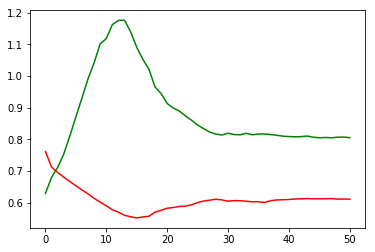

In [110]:
import torch.optim as optim 

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

def extract(v):
    return v.data.storage().tolist()

#well OK let's train the GAN on a single sequence and see what happens
def train(G, D, real_data):
    num_epochs = 5000
    print_interval = 1000
    loss_log_interval = 100
    print_stats = True
    
    discriminator_learning_rate = 1e-3
    generator_learning_rate = 1e-3
    sgd_momentum = 0.9
    
    discriminator_training_steps = 1
    generator_training_steps = 1
    
    discriminator_fake_error, discriminator_real_error = 0.0, 0.0
    generator_error = 0
    
    generator_losses = []
    discriminator_fake_losses = []
    
    criterion = nn.BCELoss() #right now the output is binary so this makes sense
    discriminator_optimizer = optim.SGD(D.parameters(), lr=discriminator_learning_rate, momentum=sgd_momentum)
    generator_optimizer = optim.SGD(G.parameters(), lr=discriminator_learning_rate, momentum=sgd_momentum)
    
    sequence_length = real_data.shape[0]
    for epoch in range(num_epochs):
        for discriminator_step in range(discriminator_training_steps):
            D.init_hidden_state()
            D.zero_grad()
            
            #Train D on the real samples
            discriminator_decision_r = D(real_data)
            discriminator_real_error = criterion(discriminator_decision_r, torch.ones(sequence_length))
            discriminator_real_error.backward()
            
            #Train D on the fake samples
            D.init_hidden_state()
            
            #create a sample of length-1 real samples and generate the last
            generator_input = real_data[:sequence_length - 2, :, :]
            fake_data = torch.zeros(sequence_length - 1, 1, real_data.shape[2])
            fake_data[:sequence_length - 2, :, :] = generator_input
            
            fake_data_element = G(generator_input).detach()
            fake_data[sequence_length - 2, :, :] = fake_data_element[2, :, :] #generate the last packet in the sequence
            discriminator_decision_f = D(fake_data)
            discriminator_fake_error = criterion(discriminator_decision_f, torch.zeros(sequence_length - 1))
            discriminator_fake_error.backward()
            discriminator_optimizer.step()
            
            dre = extract(discriminator_real_error)[0]
            dfe = extract(discriminator_fake_error)[0]
    
        for generator_step in range(generator_training_steps):
            G.init_hidden_state()
            G.zero_grad()
            D.init_hidden_state()
            D.zero_grad()
            
            generator_input = real_data[:sequence_length - 2, :, :]
            fake_data = torch.zeros(sequence_length - 1, 1, real_data.shape[2])
            fake_data[:sequence_length - 2, :, :] = generator_input
            fake_data_element = G(generator_input)
            fake_data[sequence_length - 2, :, :] = fake_data_element[2, :, :] #generate the last packet in the sequence
            
            discriminator_decision_dg = D(fake_data)
            generator_error = criterion(discriminator_decision_dg, torch.ones(sequence_length - 1))
        
            generator_error.backward()
            generator_optimizer.step()
            
            ge = extract(generator_error)[0]
            
        if epoch % loss_log_interval == 0 or epoch == num_epochs-1:
            discriminator_fake_losses.append(dfe)
            generator_losses.append(ge)
            
        if print_stats:
            if epoch % print_interval == 0 or epoch == num_epochs-1:
                print("Epoch: ", epoch)
                print("D Real Error: ", dre)
                print("D Fake Error: ", dfe)
                print("G Error: ", ge)
            
    return G, generator_losses, discriminator_fake_losses
            
gen, g_losses, df_losses = train(G,D,X_seq)
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()


In [107]:
print(decode_feature_sequence_tensor(G(X_seq).detach()))

[{'srcip': '0.0.0.0', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}, {'srcip': '0.0.0.0', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}, {'srcip': '0.0.0.0', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}, {'srcip': '0.0.0.0', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}, {'srcip': '0.0.0.0', 'dstip': '10.40.170.2', 'sport': 0, 'dport': 0}]


In [103]:
#Returns a binary vector that determines whether a particular packet 
#in a sequence will be replaced by the Generator's output.
#Worth noting that we NEVER mask the first value.
def get_mask_vector(eta = 0.2, length = None):
    if length is None:
        return None
    
    mask = []
    for k in range(0, length):
        if random.random() < eta:
            mask.append(1)
        else:
            mask.append(0)
            
    mask[0] = 0
    return mask

print(get_mask_vector(length=5))

[0, 0, 0, 1, 0]
